In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io
import itertools as it
import scipy.special as psi
plt.style.use('classic')
import seaborn as sns
import pandas as pd
import math as mt
import time
import sys

sys.path.insert(1, '/rds/general/user/lr4617/home/4th_Year_Project/Final_Year_Project/')

from scipy.io import loadmat
from scipy import stats
from numpy.random import seed
from numpy.random import rand
from scipy.integrate import quad
from scipy.io import savemat
from tempfile import TemporaryFile
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.decomposition import KernelPCA
from mpl_toolkits import mplot3d
from mPE_fn import mPE_
from scipy.spatial import distance
from scipy.stats import entropy
from mPE_ultis import integrand, ubble, array_list, permutation
from util import rolling_mean, probability_v2, get_mPE_matrix, get_vel_matrix
from sklearn.cluster import KMeans

In [2]:
rats = np.load('/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/control_analysis/rats_sampling_10_window_150_ordered.npy')
lengths = np.load('/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/control_analysis/lengths.npy')

to_be_removed = '.ipynb_checkpoints'

root_dir = '/rds/general/user/lr4617/home/4th_Year_Project/CAPTURE_rat_multidimensional/raw_data/'
normal_trajs = os.listdir(root_dir + 'normal')
drug_trajs_1 = os.listdir(root_dir + 'caffeine')
drug_trajs_2 = os.listdir(root_dir + 'amphetamine')


if to_be_removed in normal_trajs:
    idx = normal_trajs.index(to_be_removed)
    normal_trajs.pop(idx)
    normal_trajs.sort()

    
if to_be_removed in drug_trajs_1:
    idx = drug_trajs_1.index(to_be_removed)
    drug_trajs_1.pop(idx)
    drug_trajs_1.sort()

if to_be_removed in drug_trajs_2:
    idx = drug_trajs_2.index(to_be_removed)
    drug_trajs_2.pop(idx)
    drug_trajs_2.sort()

names = normal_trajs + drug_trajs_1 + drug_trajs_2

In [3]:
def get_vel_matrix_(trajectory, bins_number, traj_number, orders, random=False, least_varaince_zdim=0):
    
    if random:
        
        bins_number = 4
        
        vel_matrix = np.zeros((bins_number, traj_number, len(orders)))
        traj_length = int((trajectory.shape[0]/bins_number)/traj_number)
        
        print(vel_matrix.shape)

        for i in range(bins_number):
            
            idx = 0
            
            for j in range(0, traj_length*traj_number, traj_length):
                
                idx_1 = np.random.randint(np.max(trajectory.shape) - traj_length)
                traj = trajectory[idx_1: idx_1 + traj_length]
                traj = np.asarray(traj)
                vel_bin = 0
                last_point = traj[0, :]

                for point in traj:
                    vel_bin = vel_bin + distance.euclidean(point, last_point)
                    last_point = point
                
                vel_matrix[i, idx, 0] = vel_bin/(traj_length)
                idx += 1
        
        mPE_vector = []
        
    else:
        if trajectory.shape[0] < trajectory.shape[1]:
            trajectory =  trajectory.transpose()

        dims = 2

        mPE_vector = np.zeros((bins_number, traj_number, len(orders)))
        vel_matrix = np.zeros((bins_number, traj_number, len(orders)))

        traj_length = int((trajectory.shape[0]/bins_number)/traj_number)

        for a, order in enumerate(orders):

            for i in range(bins_number):

                idx = 0
                idx_1 = 0

                for j in range(0, traj_length*traj_number, traj_length):

                    idx_1 = i*traj_number*traj_length 
                    traj = trajectory[idx_1 + j: idx_1 + j + traj_length, :]
                    traj = np.asarray(traj)
                    vel_bin = 0
                    last_point = traj[0, :]

                    for point in traj:
                        vel_bin = vel_bin + distance.euclidean(point, last_point)
                        last_point = point

                    if traj.shape[0]>0:
                        [HH, _] = mPE_(traj, order)
                        mPE_vector[i, idx] = HH

                    vel_matrix[i, idx, a] = vel_bin/(traj_length)

                    idx += 1
                
    return mPE_vector, vel_matrix

(820800, 3)
(1695600, 3)
(2894400, 3)
(3942000, 3)


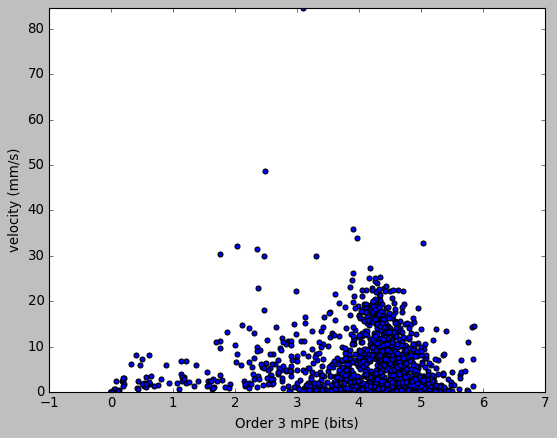

(334800, 3)
(669600, 3)
(1004400, 3)
(1339200, 3)


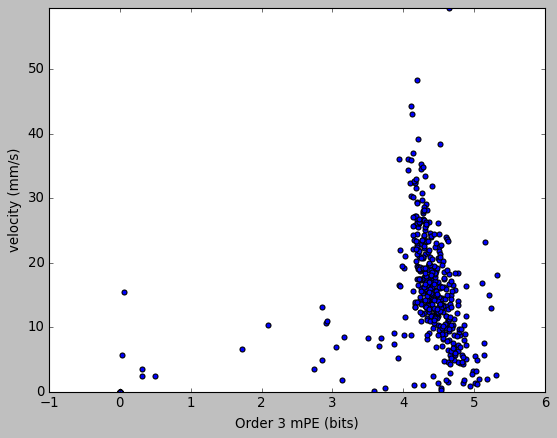

(334800, 3)
(529200, 3)
(864000, 3)
(1198800, 3)


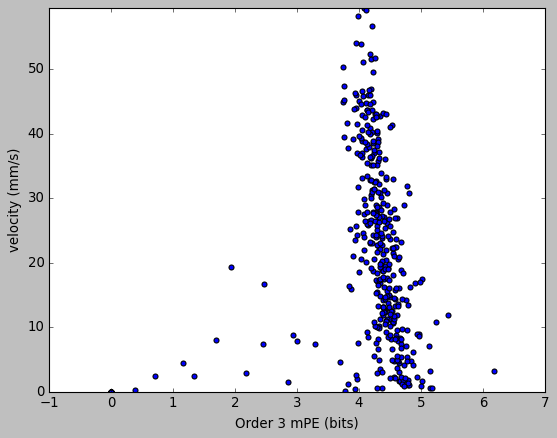

In [5]:
###################################################################################################################################################
############################################################ Velocity vs Entropy ##################################################################
###################################################################################################################################################

block_lengths = [sum(lengths[0:(i*4)+4]) for i in range(3)]
cum_lengths = [sum(lengths[0:i+1]) for i in range(1, len(lengths)+1)]

PCs = [3]
modes = ['normal', 'caffeine', 'amphetamine']
dims = [0,1,2]
idx = 0

use_all = False ## DONE
use_partition_up = False ## DONE
use_partition_down = False ## DONE
use_single = True ## DONE

if use_single:
    nPCs = [3]
    dims = np.arange(9,12)
    use_PCA = False
    add_on = 'marker'

if use_partition_up:
    nPCs = [3]
    dims_1 = np.arange(24)
    dims_2 = np.arange(36,42)
    use_PCA = True
    add_on = 'partition_up'
    
    dims = np.concatenate((dims_1,dims_2), axis=0)

if use_partition_down:
    nPCs = [3]
    dims_1 = np.arange(24,36)
    dims_2 = np.arange(42,60)
    use_PCA = True
    add_on = 'partition_down'
    
    dims = np.concatenate((dims_1,dims_2), axis=0)
    
if use_all:
    dims = np.arange(60)
    use_PCA = True
    add_on = 'all'


for n_PC in PCs:
    
    for which_traj, length in enumerate(lengths):
    
        ##### retireving single trajectory #####
        if which_traj == 0:
            idx = 0
        else:
            idx += lengths[which_traj-1]
        
        traj = rats[idx:idx+length, dims]

        if use_PCA:
            pca = PCA(n_components=n_PC)
            reduced_traj = pca.fit_transform(traj)

        else:
            reduced_traj = traj

        if which_traj%4 == 0:
            rats_reduced = reduced_traj
        else:
            rats_reduced = np.concatenate((rats_reduced, reduced_traj), axis=0)

        print(rats_reduced.shape)

        if (which_traj+1)%4 == 0:

            ################ Calculate instantaneous velocity of each datapoint (maybe only consider x-y dims) ################
            unit_length = 3000
            fs = 30
            minutes = 30
            bin_length = fs*60*minutes
            traj_number = int(bin_length/unit_length)
            bins_number = int(rats_reduced.shape[0]/bin_length)
            order = [3]

            mPE_vector, vel_matrix = get_vel_matrix_(rats_reduced, bins_number, traj_number, order)  
            
            path_out_1 = '/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/mPE_vector.npy'
            path_out_2 = '/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/vel_vector.npy'
            
            np.save(path_out_1, mPE_vector)
            np.save(path_out_2, vel_matrix)

            ################ plotting bin-velocity against corresponding mPE and polynomial fit ################
            vel_vector = vel_matrix.flatten()
            mPE_vector_ = mPE_vector.flatten()

            p = np.polyfit(mPE_vector_, vel_vector, 2)

            if order[0] == 3:
                x_new = np.linspace(4,5.8,200)
            else:
                x_new = np.linspace(6,9.2,200)

            ffit = np.polyval(p, x_new)

            fig = plt.figure()

            plt.scatter(mPE_vector_, 1000*vel_vector)
            # plt.plot(x_new, 1000*ffit)

            plt.xlabel('Order ' + str(order[0]) + ' mPE (bits)')
            plt.ylabel('velocity (mm/s)')
            plt.ylim([0, 1000*np.max(vel_vector)])

            path_out_ = '/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/entropy_analysis/mPE_vs_velocity/' + str(n_PC) + 'PC/'+ add_on + '/en_ve_' + modes[int((which_traj+1)/4 - 1)] + '.png'
            path_out = '/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/entropy_analysis/mPE_vs_velocity/' + str(n_PC) + 'PC/'+ add_on + '/en_ve_' + modes[int((which_traj+1)/4 - 1)] + '.eps'
            plt.savefig(path_out_)
            plt.savefig(path_out)
            plt.show()